In [3]:
pip install newspaper3k lxml_html_clean torch pandas numpy matplotlib seaborn scikit-learn


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 60.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.1/211.1 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Using: cuda
Epoch 1: Loss = 0.6067
Epoch 2: Loss = 0.5620
Epoch 3: Loss = 0.5620
Epoch 4: Loss = 0.5620
Epoch 5: Loss = 0.5618
Epoch 6: Loss = 0.5613
Epoch 7: Loss = 0.5613
Epoch 8: Loss = 0.5613


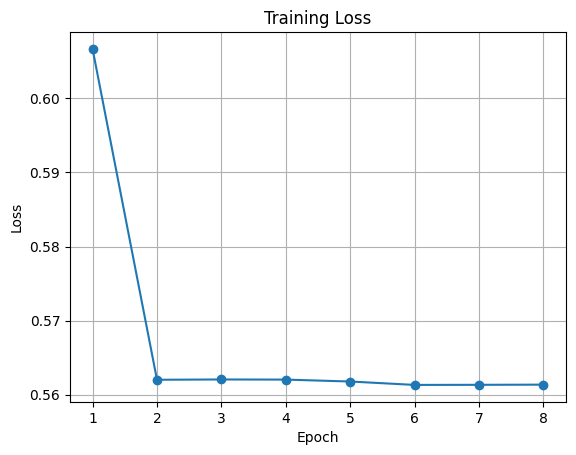

Accuracy: 0.7519396551724138
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1151
         1.0       0.75      1.00      0.86      3489

    accuracy                           0.75      4640
   macro avg       0.38      0.50      0.43      4640
weighted avg       0.57      0.75      0.65      4640



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


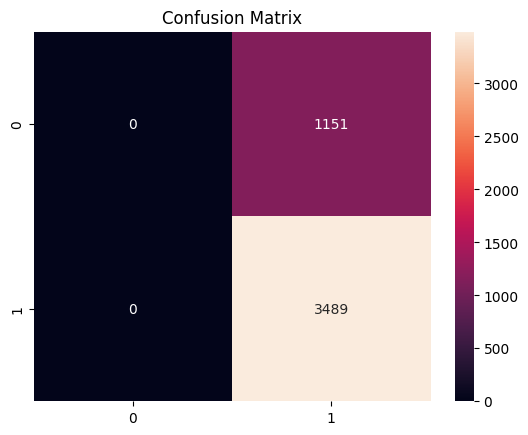


🔗 Enter a news article URL: https://www.dailymail.co.uk/femail/article-3499192/Do-blondes-REALLY-fun-Cindy-Crawford-s-model-daughter-Kaia-Gerber-puts-theory-test-peroxide-wig-dining-Harry-Styles.html

Prediction Score: 0.7484
Predicted: Fake News


<ipython-input-1-dca03d5235da>:190: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=counts, palette='viridis')


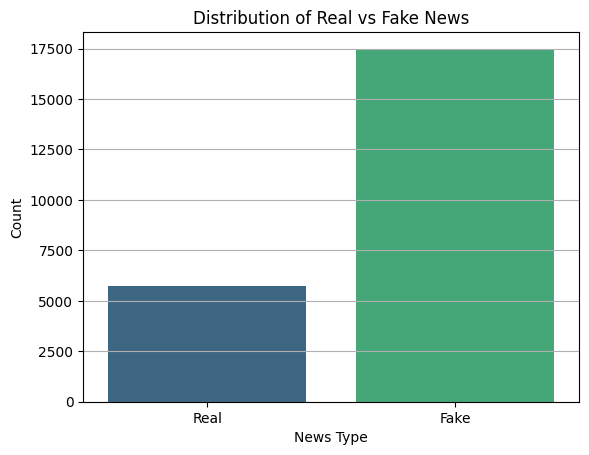

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from newspaper import Article


# Setup Device

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using:", device)

# Text Preprocessing

def basic_tokenizer(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text.strip().split()

def build_vocab(tokenized_texts, min_freq=2):
    word_counts = Counter(word for sentence in tokenized_texts for word in sentence)
    vocab = {'<pad>': 0, '<unk>': 1}
    for word, count in word_counts.items():
        if count >= min_freq:
            vocab[word] = len(vocab)
    return vocab

def encode(text, vocab):
    return [vocab.get(word, vocab['<unk>']) for word in text]

def pad_sequences(sequences, max_len, pad_value=0):
    return [seq[:max_len] + [pad_value] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len] for seq in sequences]


# Load and Clean Dataset

df = pd.read_csv(r"combined_fake_news.csv")

# Rename relevant columns
for col in ['text', 'content', 'article', 'body', 'title']:
    if col in df.columns:
        df.rename(columns={col: 'text'}, inplace=True)
        break
for col in ['label', 'class', 'category']:
    if col in df.columns:
        df.rename(columns={col: 'label'}, inplace=True)
        break

# Drop NaN values and ensure labels are 0 or 1
df = df[['text', 'label']].dropna()
df = df[df['label'].isin([0, 1])]

# Tokenize and encode
df['tokens'] = df['text'].apply(basic_tokenizer)
vocab = build_vocab(df['tokens'], min_freq=2)

MAX_LEN = 250
df['encoded'] = df['tokens'].apply(lambda x: encode(x, vocab))
df['padded'] = pad_sequences(df['encoded'], MAX_LEN, pad_value=vocab['<pad>'])

X = torch.tensor(df['padded'].tolist(), dtype=torch.long)
y = torch.tensor(df['label'].values, dtype=torch.float32)


# Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


#  Dataset and DataLoader

class NewsDataset(Dataset):
    def __init__(self, X, y): self.X, self.y = X, y
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_loader = DataLoader(NewsDataset(X_train, y_train), batch_size=128, shuffle=True)
test_loader = DataLoader(NewsDataset(X_test, y_test), batch_size=128)

# LSTM Model

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=100, hidden_dim=64):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        x = self.dropout(hidden[-1])
        return torch.sigmoid(self.fc(x))

model = LSTMClassifier(len(vocab)).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)

#  Train Model

def train_model(epochs=8):
    model.train()
    losses = []
    for epoch in range(epochs):
        total_loss = 0
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(Xb).squeeze()
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}")
        losses.append(avg_loss)
    return losses

losses = train_model()

# Plot training loss
plt.plot(range(1, len(losses)+1), losses, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()


#  Evaluate Model

def evaluate():
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for Xb, yb in test_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            outputs = model(Xb).squeeze()
            preds = (outputs > 0.5).float()
            y_true.extend(yb.tolist())
            y_pred.extend(preds.tolist())
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d')
    plt.title("Confusion Matrix")
    plt.show()

evaluate()


#  Predict from URL

def predict_from_url(url):
    article = Article(url)
    article.download()
    article.parse()
    text = article.text.lower()
    tokens = basic_tokenizer(text)
    encoded = encode(tokens, vocab)
    padded = pad_sequences([encoded], MAX_LEN, pad_value=vocab['<pad>'])
    tensor = torch.tensor(padded).long().to(device)
    model.eval()
    with torch.no_grad():
        pred = model(tensor).item()
    print(f"\nPrediction Score: {pred:.4f}")
    print("Predicted:", "Fake News" if pred > 0.5 else "Real News")

#  User Input
url = input("\n🔗 Enter a news article URL: ")
predict_from_url(url)


def plot_label_distribution():
    import matplotlib.pyplot as plt
    import seaborn as sns

    label_counts = df['label'].value_counts().sort_index()
    labels = ['Real', 'Fake']
    counts = [label_counts.get(0, 0), label_counts.get(1, 0)]

    sns.barplot(x=labels, y=counts, palette='viridis')
    plt.title('Distribution of Real vs Fake News')
    plt.ylabel('Count')
    plt.xlabel('News Type')
    plt.grid(True, axis='y')
    plt.show()

# Call the function to display the chart
plot_label_distribution()
